In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner import RandomSearch
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-08-01 13:54:37.689405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754056477.964278      14 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754056478.046764      14 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Problem Statement

The goal of this project is to detect the presence of metastatic cancer in small image patches taken from large scans. The label will map to either 0 or 1 as cancer or non-cancerous.

In [3]:
#read in the dataset
data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
img_set = '/kaggle/input/histopathologic-cancer-detection/train/'

print(data.shape)

(220025, 2)


In [4]:
#visualize data format
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Exploratory Data Analysis (EDA)

Visualize and clean the dataset. This included checking for null values, duplicates, and visualizing distribution of data such as the label(cancerous vs non-cancerous). The data set appeared clean, with no duplicates, or null values so cleaning was minimal. Pixel sizes were normalized to enhance training performance. Based on the initial EDA, the plan for analysis would be to load the data, normalize the data, and build a model to classify the image as either cancerous or non-cancerous. After that, AUC score will be used to assess model performance.

In [5]:
# check for null values in data set
print(data.isnull().sum())

# check for duplciate values
print(f"Duplicate IDs: {data['id'].duplicated().sum()}")

id       0
label    0
dtype: int64
Duplicate IDs: 0


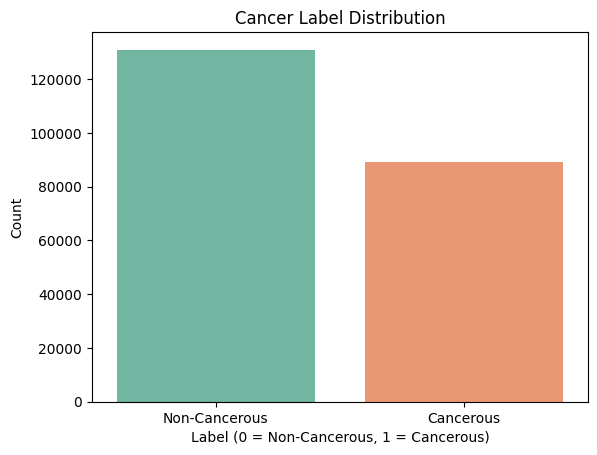

In [6]:
#Visualize the distribution of the target variable
sns.countplot(x='label', data=data, palette='Set2')
plt.title('Cancer Label Distribution')
plt.xlabel('Label (0 = Non-Cancerous, 1 = Cancerous)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])  # Optional for better labels
plt.show()



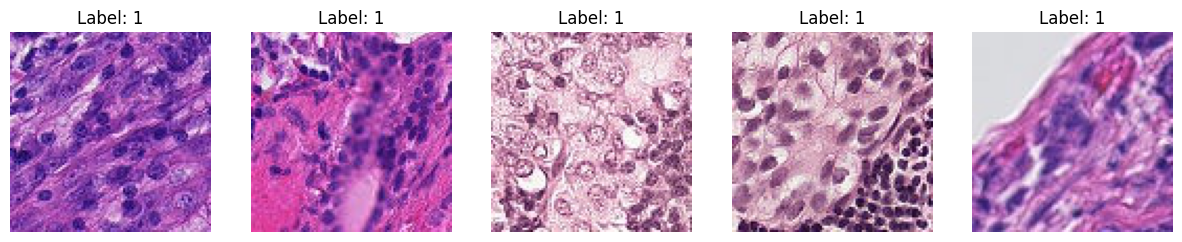

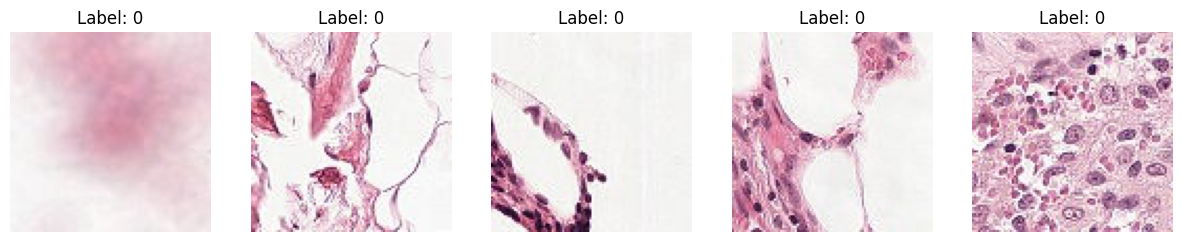

In [7]:
def plot_sample_images(df, label, img_dir, n=5):
    sample_ids = df[df['label'] == label].sample(n)['id']
    plt.figure(figsize=(15, 3))
    for i, img_id in enumerate(sample_ids):
        img_path = os.path.join(img_dir, img_id + '.tif')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

plot_sample_images(data, label=1, img_dir=img_set)
plot_sample_images(data, label=0, img_dir=img_set)


### Model Architecture

I began with a compact baseline CNN model consisting of two convolutional blocks followed by a dense layer. This architecture was chosen to establish a performance benchmark while minimizing overfitting risk and training time on moderate-sized data.

Baseline Model Configuration:

- Optimizer: Adam
- Learning Rate: 0.0005
- Dropout: None
- Batch Size: 64
- Epochs: 10
- Output Activation: Sigmoid (for binary classification)
- Loss Function: Binary Crossentropy
- Evaluation Metric: AUC (Area Under the ROC Curve)
Performance:
AUC Score: 0.871 on the validation set

This initial model performed reasonably well, indicating that even a relatively shallow network could capture key features in the data.

To improve upon the baseline, I developed a second, deeper CNN architecture with more convolutional layers, additional filters, and regularization via dropout. This allowed the model to learn more complex spatial hierarchies while controlling overfitting.

Changes in the Second Model:

- Increased number of convolutional layers (from 2 to 4)
- Increased filter sizes (e.g., 64 → 128)
- Added a Dropout layer (0.5) after convolutional blocks
- Increased dense layer size to 128 units
- Kept optimizer, learning rate, and batch size the same for fair comparison
  
This model was tuned further using hyperparameter search (e.g., dropout rate, filter size, dense units), and performance was compared using AUC and ROC curves.

In [8]:
# Sample smaller subset for faster iteration
sample_df = data.sample(10000, random_state=42)

# Load and preprocess images
def load_images(df, img_set, img_size=(96, 96)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(img_set, row['id'] + '.tif')
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize
        images.append(img)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

X, y = load_images(sample_df, img_set)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
#set-up baseline CNN model with 2 layers and fixed parameters
model = models.Sequential([
    Input(shape=(96, 96, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

early_stop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)


2025-08-01 13:56:58.004460: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 114s 888ms/step - accuracy: 0.5857 - auc: 0.6192 - loss: 0.7070 - val_accuracy: 0.7660 - val_auc: 0.8395 - val_loss: 0.5016
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 865ms/step - accuracy: 0.7699 - auc: 0.8386 - loss: 0.4893 - val_accuracy: 0.7900 - val_auc: 0.8704 - val_loss: 0.4553
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 872ms/step - accuracy: 0.7965 - auc: 0.8624 - loss: 0.4568 - val_accuracy: 0.7895 - val_auc: 0.8614 - val_loss: 0.4628
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 114s 913ms/step - accuracy: 0.7998 - auc: 0.8694 - loss: 0.4432 - val_accuracy: 0.7890 - val_auc: 0.8742 - val_loss: 0.4520
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 112s 894ms/step - accuracy: 0.8011 - auc: 0.8717 - loss: 0.4409 - val_accuracy: 0.7425 - val_auc: 0.8386 - val_loss: 0.5208
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 869ms/step - accuracy: 0.8048 - auc: 0.8771 - loss: 0.4322 - val_accuracy: 0.7985 - val_auc: 0.8765 - val_loss: 0.4363
Epoch 7/10
125/1

In [12]:
#define model pipeline for hyperparameter tuning
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(96, 96, 3)))
    
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_1_filters', [32, 64]),
        kernel_size=hp.Choice('conv_1_kernel', [3, 5]),
        activation='relu'
    ))
    
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_2_filters', [64, 128]),
        kernel_size=3,
        activation='relu'
    ))
    
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(hp.Float('dropout_rate', 0.3, 0.5, step=0.1)))

    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Choice('dense_units', [64, 128, 256]),
        activation='relu'
    ))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 5e-4, 1e-3])),
        loss='binary_crossentropy',
        metrics=[AUC(name='auc')]
    )
    
    return model




In [13]:
#check for best parameters from model, commented out as it is slow
tuner = RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=10,          
    executions_per_trial=1, 
    directory='cancer_tune',
    project_name='cnn_tune'
)

In [14]:
tuner.search(X_train, y_train,
             epochs=10,
            validation_data=(X_val, y_val),
             batch_size=64,
             callbacks=[early_stop])


Trial 10 Complete [00h 57m 35s]
val_auc: 0.8707799315452576

Best val_auc So Far: 0.883486270904541
Total elapsed time: 07h 38m 56s


In [15]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'conv_1_filters': 64, 'conv_1_kernel': 5, 'conv_2_filters': 128, 'dropout_rate': 0.3, 'dense_units': 64, 'learning_rate': 0.0001}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
#use the best parameters from the model with hyperparameter tuning to build the final model
def build_final_model():
    model = models.Sequential()
    
    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten + dense layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))

    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=[AUC(name='auc')]
    )

    return model

### Results and Analysis

Results of the two model architectures were compared using the ROC(based on AUC), since that is the metric for this competition. I also visualized the confusion matrix for the tuned model. 

The AUC value for the baseline model was 0.871. I also applied early stopping for the baseline model based on the AUC score. The AUC value for the model with the best parameters from hyperparameter tuning was 0.880. Hyperparameter tuning was done for convolutional filters, kernel sizes, dropout rates, dense layer sizes, and learning rates. The best model had the following parameters: {'conv_1_filters': 32, 'conv_1_kernel': 3, 'conv_2_filters': 128, 'dropout_rate': 0.3, 'dense_units': 64, 'learning_rate': 0.0001}. The hyperparameter tuning code was commented out as it takes some time to run and would slow down submission time. The hyperparameters identified were used to build a final model. In future iterations, I would try the best model with different optimizers as well.

In [17]:
#build model with best parameters
final_model = build_final_model()

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)

final_model.save('best_cancer_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 716ms/step - auc: 0.6449 - loss: 0.6448 - val_auc: 0.8559 - val_loss: 0.4809
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 643ms/step - auc: 0.8446 - loss: 0.4775 - val_auc: 0.8617 - val_loss: 0.4835
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 649ms/step - auc: 0.8647 - loss: 0.4509 - val_auc: 0.8685 - val_loss: 0.4522
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 654ms/step - auc: 0.8554 - loss: 0.4637 - val_auc: 0.8707 - val_loss: 0.4958
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 817ms/step - auc: 0.8657 - loss: 0.4500 - val_auc: 0.8719 - val_loss: 0.4441
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 671ms/step - auc: 0.8759 - loss: 0.4337 - val_auc: 0.8698 - val_loss: 0.4807
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 660ms/step - auc: 0.8808 - loss: 0.4290 - val_auc: 0.8742 - val_loss: 0.4378
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 659ms/step - auc: 0.8851 - loss: 0.4202 - val_auc: 0.8754 - val_loss: 0.4485
Epoch 9/10
125/125 ━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step


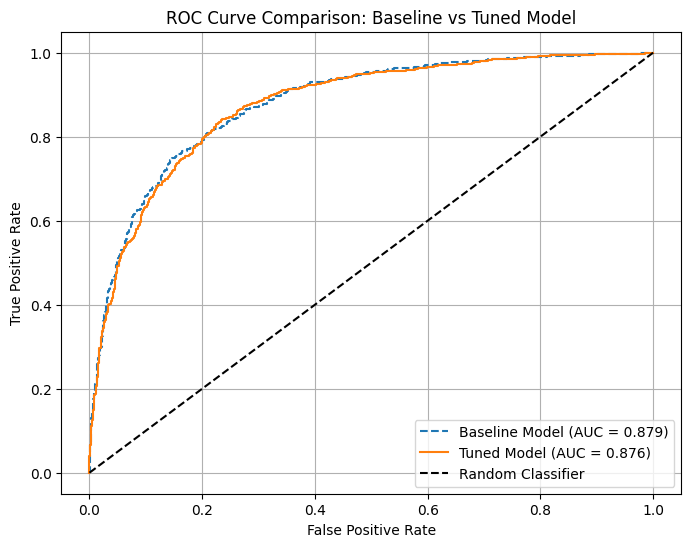

In [18]:
# Predict probabilities with baseline model
y_pred_baseline = model.predict(X_val).ravel()
fpr_base, tpr_base, _ = roc_curve(y_val, y_pred_baseline)
auc_base = auc(fpr_base, tpr_base)

# Predict probabilities with tuned best model
y_pred_tuned = final_model.predict(X_val).ravel()
fpr_final, tpr_final, _ = roc_curve(y_val, y_pred_tuned)
auc_final = auc(fpr_final, tpr_final)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, linestyle='--', label=f'Baseline Model (AUC = {auc_base:.3f})')
plt.plot(fpr_final, tpr_final, linestyle='-', label=f'Tuned Model (AUC = {auc_final:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Baseline vs Tuned Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



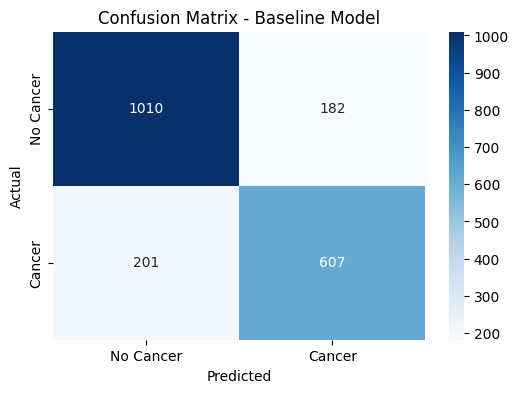

In [19]:
#confusion matrix for baseline model
y_pred_labels = (y_pred_baseline > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline Model')
plt.show()

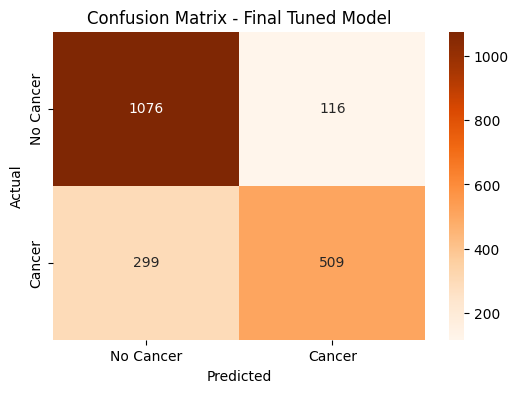

In [20]:
#confusion matrix for tuned model
y_pred_labels = (y_pred_tuned > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Final Tuned Model')
plt.show()

### Conclusion

Based on the confusion matrices, the tuned model had an increase in true negatives (TN) but a decrease in true positives (TP), suggesting that it became more conservative in flagging positive cases. This trade-off may indicate a shift in the decision threshold or possible overfitting to negative examples. In future iterations, I would try balancing the data (e.g., using oversampling or class weights) to reduce bias toward the majority class and help the model better generalize.

Additionally, I would explore tuning the classification threshold to optimize for metrics such as F1-score or recall, depending on whether false negatives or false positives are more critical in this medical context. Further improvements might also include experimenting with data augmentation, more advanced architectures like EfficientNet, or using ensembling methods to improve robustness.

Finally, evaluating model performance using precision-recall curves in addition to ROC-AUC may provide deeper insight, especially when dealing with class imbalance.

In [21]:
# Load the model
model = load_model('/kaggle/working/best_cancer_model.h5')

# Load sample submission
submission_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

# Add .tif to image ids for filename matching
submission_df['id'] = submission_df['id'].apply(lambda x: x + '.tif')

# Image generator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory='/kaggle/input/histopathologic-cancer-detection/test/',
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    batch_size=64,
    class_mode=None,
    shuffle=False
)

# Predict
predictions = model.predict(test_generator, verbose=1)

# Assign predictions (flatten if needed)
submission_df['label'] = predictions.ravel()

# Remove .tif to match submission format
submission_df['id'] = submission_df['id'].str.replace('.tif', '', regex=False)

# Save submission
submission_df.to_csv('submission.csv', index=False)



Found 57458 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 444s 495ms/step
